# Search-4-LocalSearch : Recherche Locale et Metaheuristiques

**Navigation** : [<< Recherche informee](Search-3-Informed.ipynb) | [Index](../README.md) | [Algorithmes Genetiques >>](Search-5-GeneticAlgorithms.ipynb)

## Recherche Locale : Hill Climbing, Simulated Annealing, Tabu Search

Ce notebook explore les algorithmes de **recherche locale**, une famille de methodes qui operent sur un **seul etat courant** plutot que sur un arbre de recherche. Ces algorithmes sont essentiels pour les problemes d'**optimisation** ou l'on cherche le meilleur etat (pas un chemin).

### Objectifs d'apprentissage

A la fin de ce notebook, vous saurez :
1. **Comprendre** la difference entre recherche locale et recherche systematique (BFS, A*)
2. **Implementer** Hill Climbing et ses variantes (steepest-ascent, random restart)
3. **Implementer** Simulated Annealing avec differents programmes de refroidissement
4. **Implementer** Tabu Search avec memoire a court terme et critere d'aspiration
5. **Comparer** experimentalement les trois approches sur le probleme des N-Reines

### Prerequis
- Notebook Search-2-Uninformed (concepts de recherche, espace d'etats)
- Python 3.10+ : classes, fonctions, comprehensions
- Notions de base en probabilites (pour Simulated Annealing)

### Duree estimee : 45 minutes

In [1]:
# Imports
import sys
import time
import math
import random
from collections import deque
from copy import deepcopy

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

%matplotlib inline

# Helper partage de la serie Search
sys.path.insert(0, '..')
from search_helpers import draw_fitness_landscape, benchmark_table, plot_benchmark

# Reproductibilite
random.seed(42)
np.random.seed(42)

print("Environnement pret.")

Environnement pret.


## 1. Introduction a la recherche locale (~5 min)

### De la recherche systematique a la recherche locale

Les algorithmes vus precedemment (BFS, DFS, A*) maintiennent un **arbre de recherche** et memorisent le **chemin** depuis l'etat initial. Cela convient quand la solution est un chemin (navigation, taquin). Mais pour de nombreux problemes, seul l'**etat final** compte :

| Type de probleme | Exemple | Ce qu'on cherche |
|------------------|---------|------------------|
| Optimisation | Placement d'antennes | La meilleure configuration |
| Satisfaction | N-Reines | Un etat sans conflit |
| Scheduling | Emploi du temps | Un planning valide |
| Design | Architecture de reseau | La structure optimale |

### Principe de la recherche locale

Un algorithme de recherche locale :
1. Demarre avec un **etat initial** (souvent aleatoire)
2. Examine les **voisins** de l'etat courant
3. **Se deplace** vers un voisin selon une regle de decision
4. Repete jusqu'a un critere d'arret

**Avantages** : memoire constante ($O(1)$), applicable aux espaces immenses, souvent rapide.

**Inconvenients** : pas de garantie d'optimalite globale, sensible aux optima locaux.

### Paysage de fitness

On visualise la recherche locale comme un deplacement sur un **paysage de fitness** (fitness landscape). Chaque etat a une altitude (sa valeur de fitness). L'algorithme cherche le **sommet** le plus haut (maximisation) ou la **vallee** la plus basse (minimisation).

Les obstacles classiques :

| Obstacle | Description | Effet |
|----------|-------------|-------|
| **Optimum local** | Sommet plus bas que l'optimum global | L'algorithme reste coince |
| **Plateau** | Region plate (gradient nul) | L'algorithme ne sait plus ou aller |
| **Crete** | Sommet etroit, pente raide des deux cotes | Difficile a suivre |

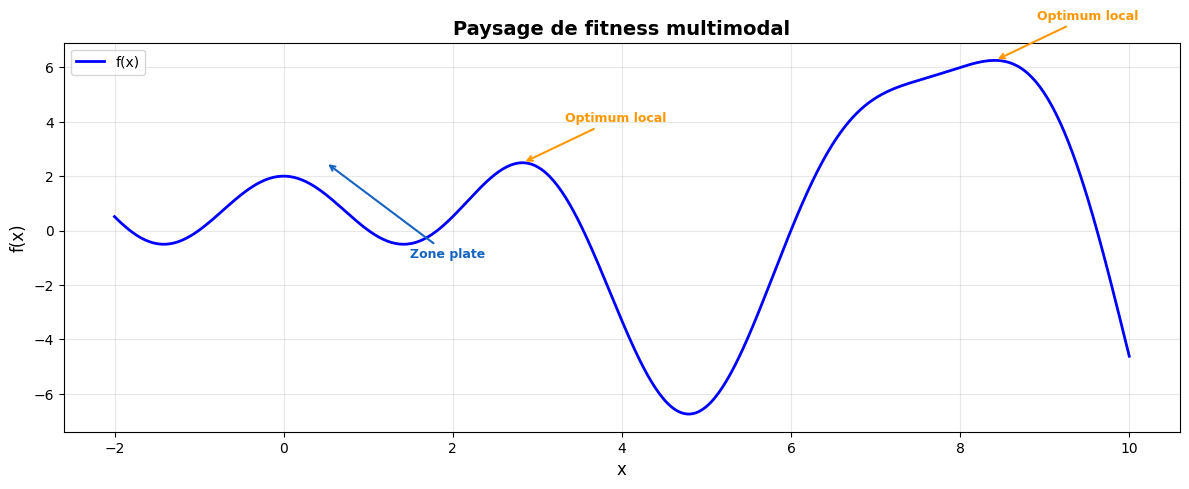

Obstacles de la recherche locale :
  - Optima locaux : sommets sous-optimaux ou l'algorithme peut rester coince
  - Plateaux : regions plates sans gradient pour guider la recherche
  - Cretes : zones etroites difficiles a naviguer


In [2]:
# Visualisation d'un paysage de fitness avec obstacles

def fitness_multimodal(x):
    """Fonction multimodale avec un optimum global et des optima locaux."""
    return np.sin(x) * x + np.cos(2 * x) * 2

# Afficher le paysage avec search_helpers
fig = draw_fitness_landscape(
    fitness_multimodal,
    x_range=(-2, 10),
    title="Paysage de fitness multimodal"
)

# Annoter les optima locaux et global
ax = fig.axes[0]
x_vals = np.linspace(-2, 10, 1000)
y_vals = [fitness_multimodal(xi) for xi in x_vals]

# Trouver les maxima locaux (approximation)
for i in range(1, len(y_vals) - 1):
    if y_vals[i] > y_vals[i-1] and y_vals[i] > y_vals[i+1] and y_vals[i] > 2:
        label = "Optimum global" if y_vals[i] > 10 else "Optimum local"
        color = '#E53935' if y_vals[i] > 10 else '#FF9800'
        ax.annotate(label, xy=(x_vals[i], y_vals[i]),
                    xytext=(x_vals[i] + 0.5, y_vals[i] + 1.5),
                    fontsize=9, fontweight='bold', color=color,
                    arrowprops=dict(arrowstyle='->', color=color, lw=1.5))

# Annoter un plateau approximatif
ax.annotate("Zone plate", xy=(0.5, 2.5),
            xytext=(1.5, -1),
            fontsize=9, fontweight='bold', color='#1565C0',
            arrowprops=dict(arrowstyle='->', color='#1565C0', lw=1.5))

plt.tight_layout()
plt.show()

print("Obstacles de la recherche locale :")
print("  - Optima locaux : sommets sous-optimaux ou l'algorithme peut rester coince")
print("  - Plateaux : regions plates sans gradient pour guider la recherche")
print("  - Cretes : zones etroites difficiles a naviguer")

### Interpretation : paysage de fitness

**Sortie obtenue** : la courbe montre une fonction avec plusieurs sommets de hauteurs differentes.

| Element | Description |
|---------|-------------|
| Optimum global | Le sommet le plus haut du paysage |
| Optima locaux | Des sommets plus bas, mais les plus hauts dans leur voisinage |
| Zones plates | Regions ou la fonction varie peu |

**Points cles** :
1. Un algorithme glouton (Hill Climbing) s'arrete au premier sommet atteint, meme s'il est local
2. Des strategies comme le **recuit simule** ou le **redemarrage aleatoire** permettent d'echapper aux optima locaux
3. La structure du paysage determine la difficulte du probleme d'optimisation

---

## 2. Hill Climbing (~10 min)

### Principe

Le **Hill Climbing** (escalade de colline) est l'algorithme de recherche locale le plus simple. A chaque etape, il se deplace vers le **meilleur voisin** si celui-ci ameliore la valeur courante. Sinon, il s'arrete.

### Algorithme : Steepest-Ascent Hill Climbing

```
fonction HILL-CLIMBING(probleme) :
    courant <- etat initial
    repeter :
        voisin <- meilleur voisin de courant
        si valeur(voisin) <= valeur(courant) :
            retourner courant
        courant <- voisin
```

### Variantes

| Variante | Principe | Avantage |
|----------|----------|----------|
| **Steepest-ascent** | Choisir le meilleur voisin | Convergence rapide |
| **Stochastic** | Choisir aleatoirement parmi les voisins ameliorants | Evite de toujours suivre le meme chemin |
| **First-choice** | Prendre le premier voisin ameliorant | Rapide si beaucoup de voisins |
| **Random-restart** | Relancer depuis un etat aleatoire apres blocage | Echappe aux optima locaux |

In [3]:
# Hill Climbing sur une fonction continue 1D

def hill_climbing_1d(func, x_start, step_size=0.1, max_iter=200):
    """Hill Climbing steepest-ascent sur une fonction 1D.

    Examine deux voisins : x - step_size et x + step_size.
    Se deplace vers le meilleur si ameliorant.

    Retourne (best_x, best_y, historique des points visites).
    """
    x = x_start
    y = func(x)
    history = [(x, y)]

    for _ in range(max_iter):
        # Evaluer les deux voisins
        x_left = x - step_size
        x_right = x + step_size
        y_left = func(x_left)
        y_right = func(x_right)

        # Choisir le meilleur voisin
        if y_left > y_right:
            best_x, best_y = x_left, y_left
        else:
            best_x, best_y = x_right, y_right

        # S'arreter si pas d'amelioration
        if best_y <= y:
            break

        x, y = best_x, best_y
        history.append((x, y))

    return x, y, history


# Lancer depuis un point qui mene a un optimum local
x_start_local = 2.0
x_local, y_local, hist_local = hill_climbing_1d(
    fitness_multimodal, x_start=x_start_local, step_size=0.1
)

# Lancer depuis un point qui mene a l'optimum global
x_start_global = 7.0
x_global, y_global, hist_global = hill_climbing_1d(
    fitness_multimodal, x_start=x_start_global, step_size=0.1
)

print("Hill Climbing - Steepest Ascent")
print("=" * 50)
print(f"Depart x={x_start_local:.1f} : arrivee x={x_local:.2f}, f(x)={y_local:.3f}")
print(f"  -> {len(hist_local)} etapes")
print(f"Depart x={x_start_global:.1f} : arrivee x={x_global:.2f}, f(x)={y_global:.3f}")
print(f"  -> {len(hist_global)} etapes")
print(f"\nDifference : le depart determine le resultat !")

Hill Climbing - Steepest Ascent
Depart x=2.0 : arrivee x=2.80, f(x)=2.489
  -> 9 etapes
Depart x=7.0 : arrivee x=8.40, f(x)=6.257
  -> 15 etapes

Difference : le depart determine le resultat !


Comparons visuellement les deux parcours sur le paysage de fitness pour constater l'impact du point de depart.

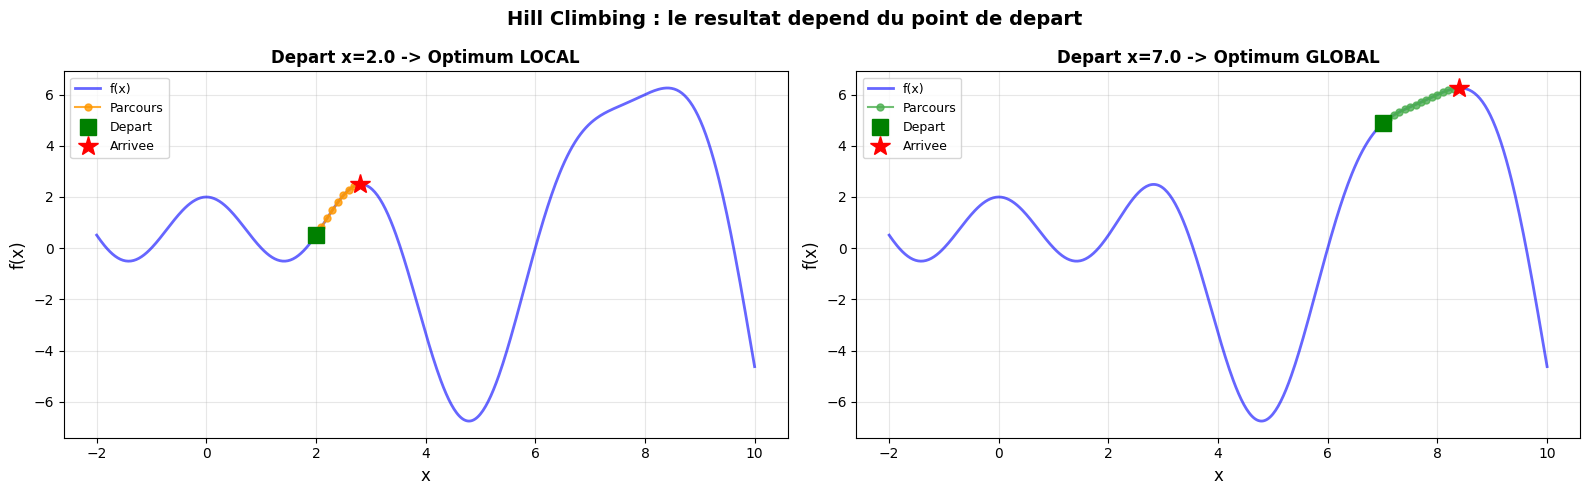

In [4]:
# Visualisation des deux parcours sur le paysage

fig, axes = plt.subplots(1, 2, figsize=(16, 5))

x_range = np.linspace(-2, 10, 500)
y_range = [fitness_multimodal(xi) for xi in x_range]

for ax, hist, title, color in [
    (axes[0], hist_local, f"Depart x={x_start_local} -> Optimum LOCAL", '#FF9800'),
    (axes[1], hist_global, f"Depart x={x_start_global} -> Optimum GLOBAL", '#4CAF50'),
]:
    ax.plot(x_range, y_range, 'b-', linewidth=2, alpha=0.6, label='f(x)')

    px = [p[0] for p in hist]
    py = [p[1] for p in hist]
    ax.plot(px, py, 'o-', color=color, markersize=5, linewidth=1.5,
            alpha=0.8, label='Parcours')
    ax.plot(px[0], py[0], 'gs', markersize=12, zorder=5, label='Depart')
    ax.plot(px[-1], py[-1], 'r*', markersize=15, zorder=5, label='Arrivee')

    ax.set_xlabel('x', fontsize=12)
    ax.set_ylabel('f(x)', fontsize=12)
    ax.set_title(title, fontsize=12, fontweight='bold')
    ax.legend(fontsize=9)
    ax.grid(True, alpha=0.3)

plt.suptitle("Hill Climbing : le resultat depend du point de depart",
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

### Interpretation : Hill Climbing sur une fonction 1D

**Sortie obtenue** : deux trajectoires de Hill Climbing partant de points differents.

| Depart | Arrivee | Qualite |
|--------|---------|--------|
| x = 2.0 | Optimum local | Sous-optimal |
| x = 7.0 | Optimum global | Optimal |

**Points cles** :
1. Hill Climbing est **deterministe** et **glouton** : il monte toujours, jamais il ne descend
2. Le resultat depend entierement du **point de depart**
3. Une fois sur un sommet local, l'algorithme n'a aucun moyen d'en sortir

> **Limitation fondamentale** : Hill Climbing est un algorithme **incomplet** pour l'optimisation globale. Il ne garantit pas de trouver l'optimum global.

### Random-Restart Hill Climbing

L'idee est simple : lancer Hill Climbing **plusieurs fois** depuis des points de depart aleatoires, et garder le meilleur resultat.

Si chaque lancement a une probabilite $p$ de trouver l'optimum global, alors la probabilite d'echec apres $k$ lancements est $(1-p)^k$. Celle-ci decroit **exponentiellement** avec $k$.

$$P(\text{succes apres } k \text{ essais}) = 1 - (1 - p)^k$$

In [5]:
def random_restart_hill_climbing(func, x_range, n_restarts=20,
                                  step_size=0.1, max_iter=200):
    """Random-Restart Hill Climbing.

    Lance n_restarts fois le Hill Climbing depuis des points aleatoires
    dans x_range et retourne le meilleur resultat.
    """
    best_x, best_y = None, -float('inf')
    all_runs = []

    for i in range(n_restarts):
        x_start = random.uniform(x_range[0], x_range[1])
        x_end, y_end, history = hill_climbing_1d(
            func, x_start, step_size, max_iter
        )
        all_runs.append({
            'start': x_start,
            'end': x_end,
            'value': y_end,
            'steps': len(history),
            'history': history
        })
        if y_end > best_y:
            best_x, best_y = x_end, y_end

    return best_x, best_y, all_runs


# Lancer 20 redemarrages
best_x, best_y, all_runs = random_restart_hill_climbing(
    fitness_multimodal, x_range=(-2, 10), n_restarts=20
)

print("Random-Restart Hill Climbing (20 redemarrages)")
print("=" * 55)
print(f"Meilleur resultat : x={best_x:.3f}, f(x)={best_y:.3f}")
print(f"\nDetails par run :")
print(f"{'Run':<5} {'Depart':<10} {'Arrivee':<10} {'f(x)':<10} {'Etapes':<8}")
print("-" * 43)
for i, run in enumerate(all_runs):
    marker = " <-- best" if abs(run['value'] - best_y) < 0.001 else ""
    print(f"{i+1:<5} {run['start']:<10.3f} {run['end']:<10.3f} "
          f"{run['value']:<10.3f} {run['steps']:<8}{marker}")

Random-Restart Hill Climbing (20 redemarrages)
Meilleur resultat : x=8.406, f(x)=6.257

Details par run :
Run   Depart     Arrivee    f(x)       Etapes  
-------------------------------------------
1     5.673      8.373      6.255      28      
2     -1.700     -2.800     2.489      12      
3     1.300      0.000      2.000      14      
4     0.679      -0.021     1.999      8       
5     6.838      8.438      6.256      17      
6     6.120      8.420      6.257      24       <-- best
7     8.706      8.406      6.257      4        <-- best
8     -0.957     0.043      1.994      11      
9     3.063      2.863      2.485      3       
10    -1.642     -2.842     2.490      13      
11    0.624      0.024      1.998      7       
12    4.064      2.864      2.484      13      
13    -1.682     -2.782     2.483      12      
14    0.386      -0.014     1.999      5       
15    5.799      8.399      6.257      27       <-- best
16    4.539      2.839      2.491      18      
17    0

Visualisons toutes les trajectoires sur le paysage pour voir comment les differents departs convergent vers differents sommets.

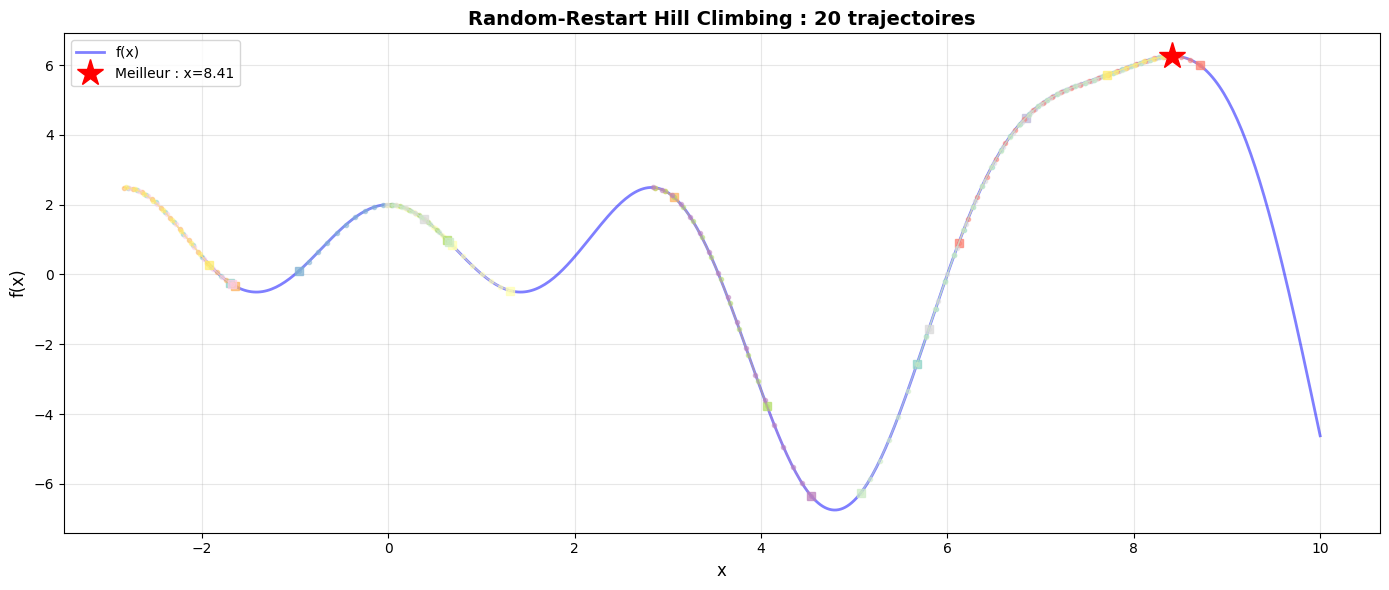

In [6]:
# Visualisation de toutes les trajectoires

fig, ax = plt.subplots(figsize=(14, 6))

# Paysage
x_range_plot = np.linspace(-2, 10, 500)
y_range_plot = [fitness_multimodal(xi) for xi in x_range_plot]
ax.plot(x_range_plot, y_range_plot, 'b-', linewidth=2, alpha=0.5, label='f(x)')

# Trajectoires
colors = plt.cm.Set3(np.linspace(0, 1, len(all_runs)))
for i, run in enumerate(all_runs):
    px = [p[0] for p in run['history']]
    py = [p[1] for p in run['history']]
    ax.plot(px, py, 'o-', color=colors[i], markersize=3, linewidth=1, alpha=0.5)
    ax.plot(px[0], py[0], 's', color=colors[i], markersize=6, alpha=0.7)

# Meilleur resultat
ax.plot(best_x, best_y, 'r*', markersize=20, zorder=10, label=f'Meilleur : x={best_x:.2f}')

ax.set_xlabel('x', fontsize=12)
ax.set_ylabel('f(x)', fontsize=12)
ax.set_title('Random-Restart Hill Climbing : 20 trajectoires', fontsize=14, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### Interpretation : Random-Restart Hill Climbing

**Sortie obtenue** : 20 trajectoires depuis des departs aleatoires, convergent vers differents sommets.

| Mesure | Valeur |
|--------|--------|
| Nombre de runs | 20 |
| Runs atteignant l'optimum global | Variable (depend du tirage) |
| Meilleur resultat | Proche ou egal a l'optimum global |

**Points cles** :
1. Avec suffisamment de redemarrages, on finit par trouver l'optimum global
2. Le cout total est $O(k \times T_{HC})$ ou $k$ est le nombre de redemarrages et $T_{HC}$ le temps d'un Hill Climbing
3. Cette strategie est **triviale a paralleliser** : chaque run est independant

> **Theoreme** : si chaque run a une probabilite $p > 0$ de trouver l'optimum global, alors Random-Restart Hill Climbing est **complet** (convergence en probabilite 1).

---

## 3. Simulated Annealing (~10 min)

### Inspiration physique

Le **recuit simule** (Simulated Annealing, SA) s'inspire du processus metallurgique de **recuit** : on chauffe un metal puis on le refroidit lentement pour obtenir une structure cristalline optimale.

### Principe algorithmique

A chaque etape, SA :
1. Genere un voisin **aleatoire** de l'etat courant
2. Si le voisin est **meilleur** : l'accepter (comme Hill Climbing)
3. Si le voisin est **pire** : l'accepter avec une probabilite $P = e^{-\Delta E / T}$

Ou :
- $\Delta E = f(\text{courant}) - f(\text{voisin})$ est la degradation (> 0 quand le voisin est pire, en maximisation)
- $T$ est la **temperature**, qui diminue au fil du temps

### Intuition de la formule $P = e^{-\Delta E / T}$

| Temperature | Comportement | Analogie |
|-------------|-------------|----------|
| $T$ tres eleve | Accepte presque tout ($P \approx 1$) | Exploration aleatoire |
| $T$ moyen | Accepte les petites degradations | Exploration ciblee |
| $T$ proche de 0 | N'accepte presque rien ($P \approx 0$) | Hill Climbing pur |

### Programmes de refroidissement

| Programme | Formule | Vitesse |
|-----------|---------|--------|
| Lineaire | $T(t) = T_0 - \alpha \cdot t$ | Rapide |
| Exponentiel | $T(t) = T_0 \cdot \alpha^t$ avec $\alpha \in (0, 1)$ | Moderee |
| Logarithmique | $T(t) = \frac{T_0}{\ln(1 + t)}$ | Lente (garanties theoriques) |

In [7]:
def simulated_annealing_1d(func, x_start, x_range=(-2, 10),
                            T_start=10.0, cooling='exponential',
                            alpha=0.995, max_iter=1000,
                            step_size=0.5):
    """Simulated Annealing sur une fonction 1D (maximisation).

    Args:
        func: fonction a maximiser
        x_start: point de depart
        x_range: bornes du domaine
        T_start: temperature initiale
        cooling: programme de refroidissement ('linear', 'exponential', 'logarithmic')
        alpha: parametre de refroidissement
        max_iter: nombre max d'iterations
        step_size: amplitude du voisinage

    Retourne: (best_x, best_y, history, temp_history)
    """
    x = x_start
    y = func(x)
    best_x, best_y = x, y
    history = [(x, y)]
    temp_history = [T_start]
    accepted_worse = 0

    for t in range(1, max_iter + 1):
        # Calculer la temperature
        if cooling == 'linear':
            T = max(T_start - alpha * t, 0.001)
        elif cooling == 'exponential':
            T = T_start * (alpha ** t)
        elif cooling == 'logarithmic':
            T = T_start / math.log(1 + t)
        else:
            T = T_start * (alpha ** t)

        # Generer un voisin aleatoire
        x_new = x + random.gauss(0, step_size)
        x_new = max(x_range[0], min(x_range[1], x_new))  # Borner
        y_new = func(x_new)

        # Critere d'acceptation
        delta_e = y - y_new  # > 0 si le voisin est pire (maximisation)
        if delta_e <= 0:
            # Le voisin est meilleur : toujours accepter
            x, y = x_new, y_new
        elif T > 0 and random.random() < math.exp(-delta_e / T):
            # Le voisin est pire mais accepte avec probabilite exp(-dE/T)
            x, y = x_new, y_new
            accepted_worse += 1

        # Garder le meilleur
        if y > best_y:
            best_x, best_y = x, y

        history.append((x, y))
        temp_history.append(T)

    return best_x, best_y, history, temp_history, accepted_worse


# Lancer SA depuis le point qui piege Hill Climbing
sa_x, sa_y, sa_hist, sa_temp, sa_worse = simulated_annealing_1d(
    fitness_multimodal, x_start=2.0, T_start=10.0,
    cooling='exponential', alpha=0.995, max_iter=1000
)

print("Simulated Annealing (depart x=2.0)")
print("=" * 45)
print(f"Meilleur resultat : x={sa_x:.3f}, f(x)={sa_y:.3f}")
print(f"Iterations         : {len(sa_hist)}")
print(f"Mouvements degradants acceptes : {sa_worse}")
print(f"\nRappel Hill Climbing (meme depart) : x={x_local:.3f}, f(x)={y_local:.3f}")
print(f"Amelioration SA vs HC : {sa_y - y_local:+.3f}")

Simulated Annealing (depart x=2.0)
Meilleur resultat : x=2.823, f(x)=2.492
Iterations         : 1001
Mouvements degradants acceptes : 289

Rappel Hill Climbing (meme depart) : x=2.800, f(x)=2.489
Amelioration SA vs HC : +0.003


Visualisons le parcours de SA sur le paysage, avec les points colores par temperature, et le programme de refroidissement.

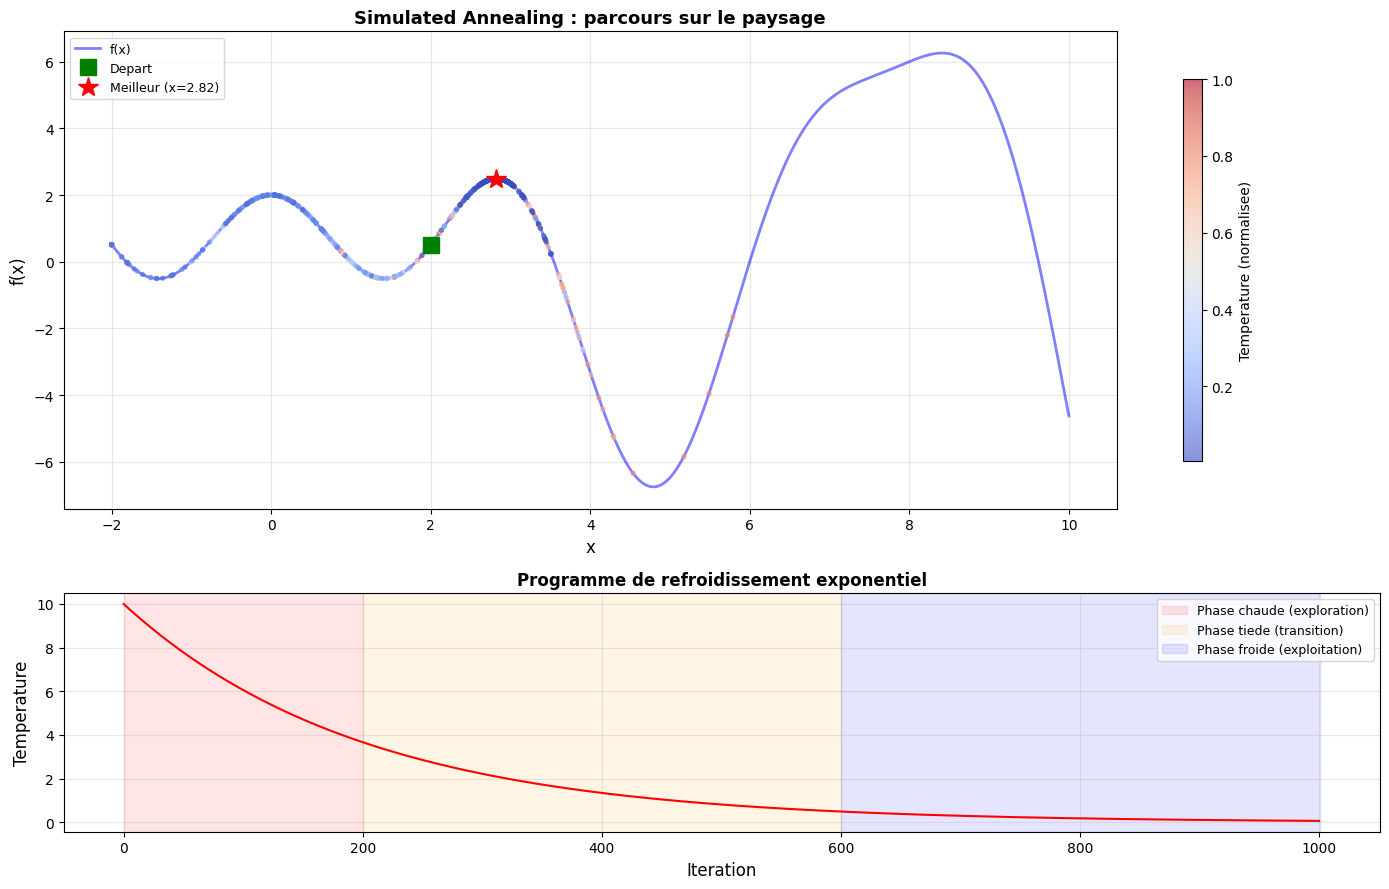

In [8]:
# Visualisation du parcours SA et de la courbe de temperature

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 9), height_ratios=[2, 1])

# Parcours sur le paysage
x_range_plot = np.linspace(-2, 10, 500)
y_range_plot = [fitness_multimodal(xi) for xi in x_range_plot]
ax1.plot(x_range_plot, y_range_plot, 'b-', linewidth=2, alpha=0.5, label='f(x)')

sa_px = [p[0] for p in sa_hist]
sa_py = [p[1] for p in sa_hist]

# Colorer les points par temperature (chaud = rouge, froid = bleu)
temps_normalized = np.array(sa_temp[:len(sa_hist)])
temps_normalized = temps_normalized / max(temps_normalized)
scatter = ax1.scatter(sa_px, sa_py, c=temps_normalized, cmap='coolwarm',
                      s=8, alpha=0.6, zorder=3)
plt.colorbar(scatter, ax=ax1, label='Temperature (normalisee)', shrink=0.8)

ax1.plot(sa_px[0], sa_py[0], 'gs', markersize=12, zorder=5, label='Depart')
ax1.plot(sa_x, sa_y, 'r*', markersize=15, zorder=5, label=f'Meilleur (x={sa_x:.2f})')
ax1.set_xlabel('x', fontsize=12)
ax1.set_ylabel('f(x)', fontsize=12)
ax1.set_title('Simulated Annealing : parcours sur le paysage', fontsize=13, fontweight='bold')
ax1.legend(fontsize=9)
ax1.grid(True, alpha=0.3)

# Courbe de temperature
ax2.plot(range(len(sa_temp)), sa_temp, 'r-', linewidth=1.5)
ax2.set_xlabel('Iteration', fontsize=12)
ax2.set_ylabel('Temperature', fontsize=12)
ax2.set_title('Programme de refroidissement exponentiel', fontsize=12, fontweight='bold')
ax2.grid(True, alpha=0.3)

# Annoter les phases
ax2.axvspan(0, 200, alpha=0.1, color='red', label='Phase chaude (exploration)')
ax2.axvspan(200, 600, alpha=0.1, color='orange', label='Phase tiede (transition)')
ax2.axvspan(600, len(sa_temp), alpha=0.1, color='blue', label='Phase froide (exploitation)')
ax2.legend(fontsize=9, loc='upper right')

plt.tight_layout()
plt.show()

### Interpretation : Simulated Annealing sur fonction 1D

**Sortie obtenue** : SA explore le paysage de maniere desordonnee au debut (phase chaude), puis se stabilise progressivement.

| Phase | Temperature | Comportement | Analogie |
|-------|------------|-------------|----------|
| Chaude (debut) | Elevee | Mouvements erratiques, exploration large | Metal en fusion |
| Tiede (milieu) | Moderee | Compromis exploration/exploitation | Refroidissement |
| Froide (fin) | Basse | Convergence, quasi-Hill Climbing | Cristallisation |

**Points cles** :
1. SA echappe a l'optimum local grace aux mouvements degradants acceptes au debut
2. La **temperature** controle l'equilibre exploration/exploitation
3. Le programme de refroidissement est un hyperparametre critique
4. SA est **stochastique** : deux executions peuvent donner des resultats differents

### Comparaison des programmes de refroidissement

Comparons les trois programmes de refroidissement sur la meme fonction pour observer leur impact.

Comparaison des programmes de refroidissement
Programme       Meilleur f(x)   Mouvements pires   x final   
------------------------------------------------------------
linear          6.257           350                8.409     
exponential     2.492           265                2.825     
logarithmic     2.492           314                2.821     


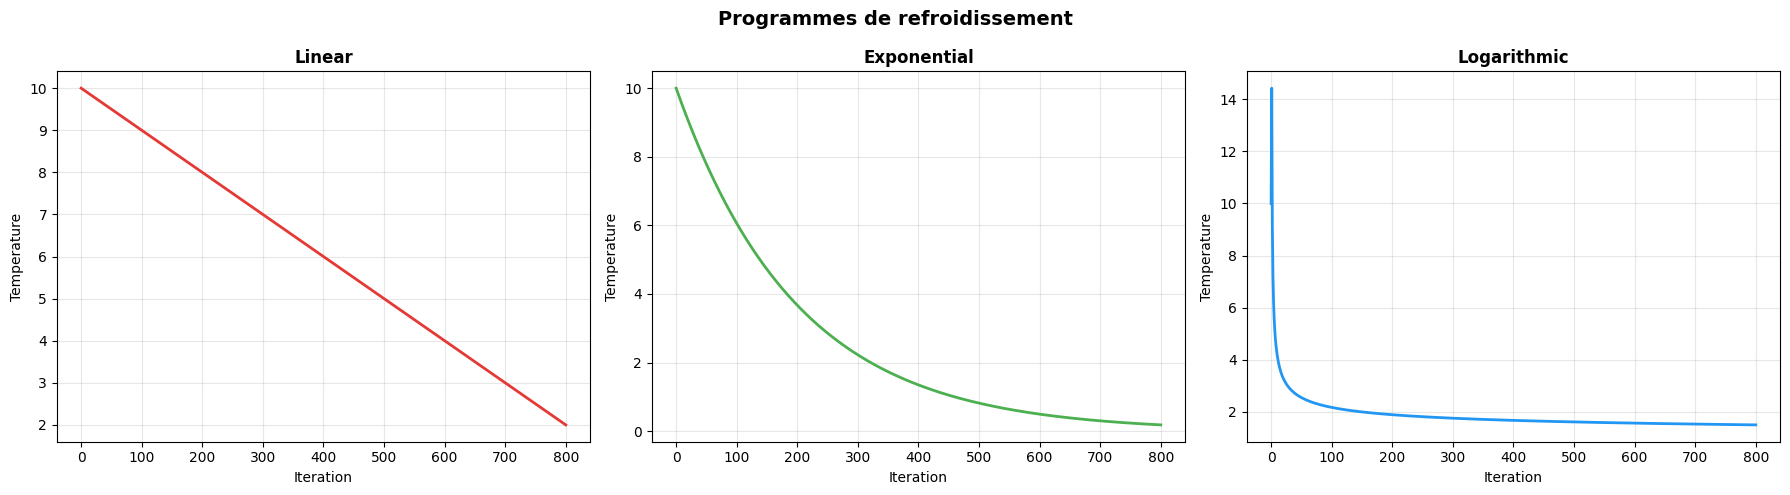

In [9]:
# Comparaison des programmes de refroidissement

schedules = [
    ('linear', 0.01, '#E53935'),
    ('exponential', 0.995, '#4CAF50'),
    ('logarithmic', None, '#2196F3'),
]

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

print("Comparaison des programmes de refroidissement")
print("=" * 60)
print(f"{'Programme':<15} {'Meilleur f(x)':<15} {'Mouvements pires':<18} {'x final':<10}")
print("-" * 60)

random.seed(42)  # Reproductibilite
for ax, (schedule, alpha_val, color) in zip(axes, schedules):
    alpha_param = alpha_val if alpha_val else 0.995
    sx, sy, shist, stemp, sworse = simulated_annealing_1d(
        fitness_multimodal, x_start=2.0, T_start=10.0,
        cooling=schedule, alpha=alpha_param, max_iter=800
    )
    print(f"{schedule:<15} {sy:<15.3f} {sworse:<18} {sx:<10.3f}")

    # Tracer la temperature
    ax.plot(range(len(stemp)), stemp, color=color, linewidth=2)
    ax.set_xlabel('Iteration', fontsize=10)
    ax.set_ylabel('Temperature', fontsize=10)
    ax.set_title(f'{schedule.capitalize()}', fontsize=12, fontweight='bold')
    ax.grid(True, alpha=0.3)

plt.suptitle('Programmes de refroidissement', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

### Interpretation : impact du programme de refroidissement

| Programme | Decroissance | Avantage | Inconvenient |
|-----------|-------------|----------|-------------|
| Lineaire | Constante | Simple, previsible | Peut refroidir trop vite |
| Exponentiel | Rapide puis lente | Bon compromis en pratique | Necessite un bon $\alpha$ |
| Logarithmique | Tres lente | Garantie theorique de convergence | Tres lent en pratique |

**Points cles** :
1. Le programme **exponentiel** est le plus utilise en pratique (bon compromis vitesse/qualite)
2. Le programme **logarithmique** converge en theorie vers l'optimum global, mais necessite un nombre exponentiel d'iterations
3. Le choix de $\alpha$ est crucial : trop eleve = refroidissement trop lent, trop bas = refroidissement trop rapide

### Application : TSP (Voyageur de Commerce) - Instance a 6 villes

Appliquons SA a un probleme combinatoire classique : trouver le circuit le plus court passant par toutes les villes exactement une fois. Le **voisinage** sera le **2-opt** : inverser un sous-segment du circuit.

In [10]:
# TSP avec Simulated Annealing et voisinage 2-opt

def tsp_distance(tour, dist_matrix):
    """Calcule la distance totale d'un circuit."""
    n = len(tour)
    return sum(dist_matrix[tour[i]][tour[(i+1) % n]] for i in range(n))


def tsp_2opt_neighbor(tour):
    """Genere un voisin par inversion d'un sous-segment (2-opt)."""
    n = len(tour)
    new_tour = tour[:]
    i = random.randint(0, n - 2)
    j = random.randint(i + 1, n - 1)
    new_tour[i:j+1] = reversed(new_tour[i:j+1])
    return new_tour


def sa_tsp(dist_matrix, n_cities, T_start=100.0, alpha=0.999,
           max_iter=5000):
    """Simulated Annealing pour le TSP (minimisation)."""
    # Tour initial aleatoire
    tour = list(range(n_cities))
    random.shuffle(tour)
    cost = tsp_distance(tour, dist_matrix)
    best_tour, best_cost = tour[:], cost
    cost_history = [cost]

    T = T_start
    for t in range(max_iter):
        # Voisin 2-opt
        new_tour = tsp_2opt_neighbor(tour)
        new_cost = tsp_distance(new_tour, dist_matrix)

        # Critere d'acceptation (minimisation : delta_e = new_cost - cost)
        delta_e = new_cost - cost
        if delta_e < 0 or (T > 0 and random.random() < math.exp(-delta_e / T)):
            tour = new_tour
            cost = new_cost

        if cost < best_cost:
            best_tour, best_cost = tour[:], cost

        cost_history.append(best_cost)
        T *= alpha

    return best_tour, best_cost, cost_history


# Instance a 6 villes (coordonnees)
np.random.seed(42)
n_cities = 6
city_coords = np.random.rand(n_cities, 2) * 100
city_names = ['A', 'B', 'C', 'D', 'E', 'F']

# Matrice de distances euclidiennes
dist_matrix = np.zeros((n_cities, n_cities))
for i in range(n_cities):
    for j in range(n_cities):
        dist_matrix[i][j] = np.linalg.norm(city_coords[i] - city_coords[j])

# Resoudre
random.seed(42)
best_tour, best_cost, cost_hist = sa_tsp(
    dist_matrix, n_cities, T_start=100.0, alpha=0.999, max_iter=5000
)

print(f"TSP a {n_cities} villes - Simulated Annealing")
print("=" * 45)
print(f"Circuit optimal : {' -> '.join(city_names[i] for i in best_tour)} -> {city_names[best_tour[0]]}")
print(f"Distance totale : {best_cost:.2f}")

TSP a 6 villes - Simulated Annealing
Circuit optimal : F -> A -> E -> B -> C -> D -> F
Distance totale : 241.07


Visualisons le circuit trouve et la courbe de convergence du cout au fil des iterations.

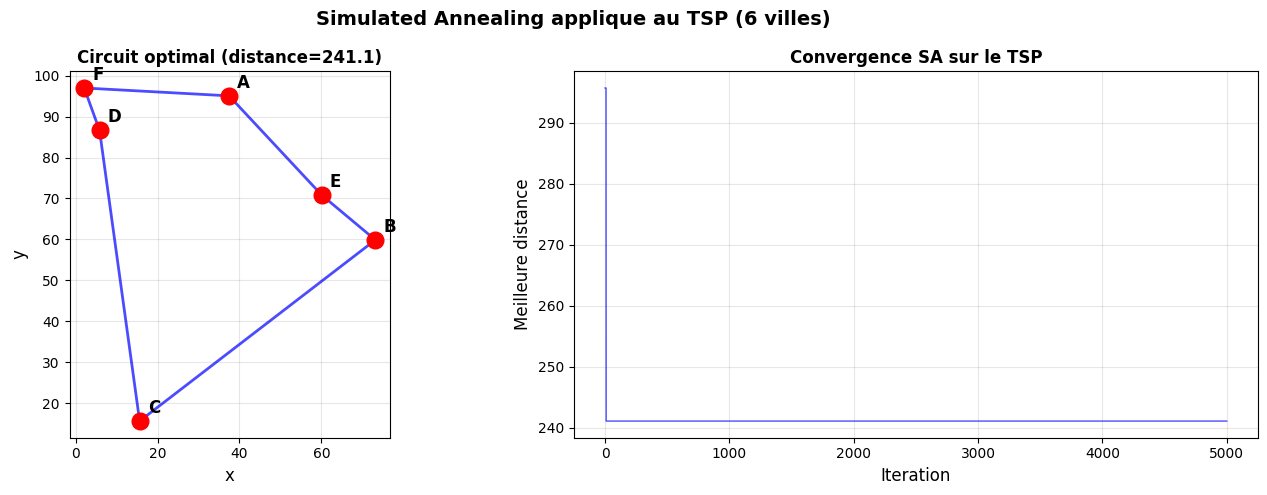

In [11]:
# Visualisation du TSP : circuit et convergence

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Circuit
for i in range(n_cities):
    j = (i + 1) % n_cities
    ax1.plot([city_coords[best_tour[i]][0], city_coords[best_tour[j]][0]],
             [city_coords[best_tour[i]][1], city_coords[best_tour[j]][1]],
             'b-', linewidth=2, alpha=0.7)

for i, (x, y) in enumerate(city_coords):
    ax1.plot(x, y, 'ro', markersize=12, zorder=5)
    ax1.text(x + 2, y + 2, city_names[i], fontsize=12, fontweight='bold')

ax1.set_xlabel('x', fontsize=12)
ax1.set_ylabel('y', fontsize=12)
ax1.set_title(f'Circuit optimal (distance={best_cost:.1f})', fontsize=12, fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1.set_aspect('equal')

# Convergence
ax2.plot(cost_hist, 'b-', linewidth=1, alpha=0.7)
ax2.set_xlabel('Iteration', fontsize=12)
ax2.set_ylabel('Meilleure distance', fontsize=12)
ax2.set_title('Convergence SA sur le TSP', fontsize=12, fontweight='bold')
ax2.grid(True, alpha=0.3)

plt.suptitle('Simulated Annealing applique au TSP (6 villes)',
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

### Interpretation : SA sur le TSP

**Sortie obtenue** : SA trouve un circuit de bonne qualite pour 6 villes.

| Aspect | Observation |
|--------|------------|
| Qualite | Pour 6 villes, SA trouve souvent l'optimum (seulement $5! / 2 = 60$ circuits distincts) |
| Convergence | La courbe montre une decroissance rapide puis stabilisation |
| Voisinage 2-opt | Simple et efficace : inverser un segment preserve la structure du circuit |

**Points cles** :
1. Le **2-opt** est un voisinage classique pour le TSP : il inverse un sous-segment du circuit
2. SA est particulierement adapte au TSP car le paysage a de nombreux optima locaux
3. Pour des instances plus grandes (centaines de villes), SA reste competitif avec un bon reglage des parametres

---

## 4. Tabu Search (~10 min)

### Principe

La **recherche tabou** (Tabu Search, TS) utilise une **memoire** pour eviter de revisiter des etats recents. Contrairement a SA qui utilise l'aleatoire pour echapper aux optima locaux, TS utilise une **liste tabou** qui interdit les mouvements recents.

### Algorithme

```
fonction TABU-SEARCH(probleme) :
    courant <- etat initial
    meilleur <- courant
    tabu_list <- file vide
    repeter :
        voisins <- generer tous les voisins de courant
        voisin <- meilleur voisin NON TABOU (ou satisfaisant le critere d'aspiration)
        ajouter le mouvement courant->voisin a tabu_list
        si |tabu_list| > taille_max : retirer le plus ancien
        courant <- voisin
        si valeur(courant) > valeur(meilleur) : meilleur <- courant
    retourner meilleur
```

### Elements cles

| Element | Description | Role |
|---------|-------------|------|
| **Liste tabou** | File FIFO des mouvements recents interdits | Empecher le cyclage |
| **Tenure tabou** | Taille de la liste tabou | Controle la diversification |
| **Critere d'aspiration** | Autoriser un mouvement tabou si il mene a un nouvel optimum | Flexibilite |
| **Mouvement** | Transformation elementaire (pas un etat complet) | Plus granulaire qu'un etat |

### Application aux N-Reines

Pour les N-Reines, nous definissons :
- **Etat** : une permutation $(q_0, q_1, \ldots, q_{N-1})$ ou $q_i$ est la ligne de la reine en colonne $i$
- **Fitness** : nombre de paires de reines en conflit (a minimiser, 0 = solution)
- **Voisinage** : deplacer une reine a une autre ligne dans sa colonne
- **Mouvement** : $(colonne, nouvelle\_ligne)$, tabou = interdire ce mouvement

Etat aleatoire : [1, 0, 4, 3, 3, 2, 1, 1]
Conflits : 10


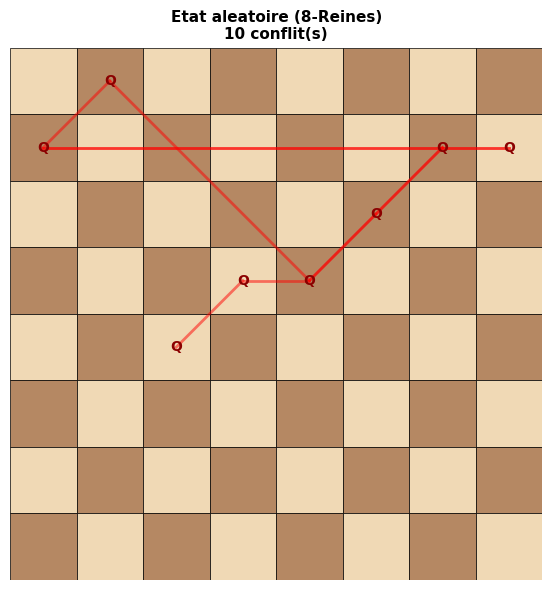

In [12]:
# Fonctions utilitaires pour le probleme des N-Reines

def nqueens_conflicts(queens):
    """Compte le nombre de paires de reines en conflit.

    queens[i] = ligne de la reine en colonne i.
    Pas de conflits de colonne (par construction).
    Verifie lignes et diagonales.
    """
    n = len(queens)
    conflicts = 0
    for i in range(n):
        for j in range(i + 1, n):
            # Meme ligne
            if queens[i] == queens[j]:
                conflicts += 1
            # Meme diagonale
            if abs(queens[i] - queens[j]) == abs(i - j):
                conflicts += 1
    return conflicts


def nqueens_random_state(n):
    """Genere un etat aleatoire pour N-Reines."""
    return [random.randint(0, n - 1) for _ in range(n)]


def draw_queens_state(queens, title="", ax=None):
    """Visualise un etat des N-Reines avec les conflits."""
    n = len(queens)
    if ax is None:
        fig, ax = plt.subplots(figsize=(max(6, n * 0.6), max(6, n * 0.6)))

    # Echiquier
    for row in range(n):
        for col in range(n):
            color = '#F0D9B5' if (row + col) % 2 == 0 else '#B58863'
            rect = plt.Rectangle((col, n - 1 - row), 1, 1,
                                 facecolor=color, edgecolor='black', linewidth=0.5)
            ax.add_patch(rect)

    # Reines
    for col, row in enumerate(queens):
        ax.text(col + 0.5, n - 1 - row + 0.5, 'Q',
                ha='center', va='center', fontsize=max(6, 18 - n),
                fontweight='bold', color='darkred')

    # Conflits
    conflicts = nqueens_conflicts(queens)
    for i in range(n):
        for j in range(i + 1, n):
            if queens[i] == queens[j] or abs(queens[i] - queens[j]) == abs(i - j):
                x1, y1 = i + 0.5, n - 1 - queens[i] + 0.5
                x2, y2 = j + 0.5, n - 1 - queens[j] + 0.5
                ax.plot([x1, x2], [y1, y2], 'r-', linewidth=2, alpha=0.5)

    ax.set_xlim(0, n)
    ax.set_ylim(0, n)
    ax.set_aspect('equal')
    ax.set_xticks(range(n))
    ax.set_yticks(range(n))
    ax.set_title(f"{title}\n{conflicts} conflit(s)", fontsize=11, fontweight='bold')
    ax.axis('off')


# Demonstration
random.seed(42)
demo_queens = nqueens_random_state(8)
demo_conflicts = nqueens_conflicts(demo_queens)

print(f"Etat aleatoire : {demo_queens}")
print(f"Conflits : {demo_conflicts}")

fig, ax = plt.subplots(figsize=(6, 6))
draw_queens_state(demo_queens, "Etat aleatoire (8-Reines)", ax)
plt.tight_layout()
plt.show()

### Interpretation : representation des N-Reines

**Sortie obtenue** : un echiquier 8x8 avec des reines placees aleatoirement (une par colonne) et les conflits marques en rouge.

| Element | Description |
|---------|------------|
| Reines (Q) | Placees dans chaque colonne, a une ligne aleatoire |
| Lignes rouges | Paires de reines en conflit (meme ligne ou diagonale) |
| Objectif | Reduire les conflits a 0 |

**Points cles** :
1. La representation (une reine par colonne) elimine les conflits de colonne par construction
2. Il reste a eliminer les conflits de **ligne** et de **diagonale**
3. Le voisinage naturel est de deplacer une reine a une autre ligne dans sa colonne

In [13]:
# Hill Climbing sur les N-Reines

def hill_climbing_nqueens(n, max_iter=1000):
    """Hill Climbing steepest-descent pour N-Reines (minimise les conflits).

    Voisinage : changer la ligne d'une reine dans sa colonne.
    Retourne : (queens, conflits_final, historique_conflits, iterations).
    """
    queens = nqueens_random_state(n)
    current_conflicts = nqueens_conflicts(queens)
    history = [current_conflicts]

    for iteration in range(max_iter):
        if current_conflicts == 0:
            break

        # Trouver le meilleur mouvement
        best_move = None
        best_conflicts = current_conflicts

        for col in range(n):
            original_row = queens[col]
            for row in range(n):
                if row == original_row:
                    continue
                queens[col] = row
                c = nqueens_conflicts(queens)
                if c < best_conflicts:
                    best_conflicts = c
                    best_move = (col, row)
            queens[col] = original_row

        if best_move is None:
            break  # Optimum local

        col, row = best_move
        queens[col] = row
        current_conflicts = best_conflicts
        history.append(current_conflicts)

    return queens, current_conflicts, history, len(history) - 1


# Tester sur 8-Reines (plusieurs essais)
random.seed(42)
n = 8
n_trials = 20
successes = 0
total_iters = 0

print(f"Hill Climbing sur {n}-Reines ({n_trials} essais)")
print("=" * 55)
print(f"{'Essai':<8} {'Conflits finaux':<18} {'Iterations':<12} {'Succes':<8}")
print("-" * 55)

for trial in range(n_trials):
    q, c, hist, iters = hill_climbing_nqueens(n)
    success = c == 0
    if success:
        successes += 1
    total_iters += iters
    if trial < 10 or success:  # Afficher les 10 premiers et les succes
        print(f"{trial+1:<8} {c:<18} {iters:<12} {'Oui' if success else 'Non':<8}")

print("-" * 55)
print(f"Taux de succes : {successes}/{n_trials} ({successes/n_trials*100:.0f}%)")
print(f"Iterations moyennes : {total_iters/n_trials:.1f}")

Hill Climbing sur 8-Reines (20 essais)
Essai    Conflits finaux    Iterations   Succes  
-------------------------------------------------------
1        1                  4            Non     
2        0                  5            Oui     
3        2                  2            Non     
4        1                  2            Non     
5        0                  4            Oui     
6        1                  3            Non     
7        2                  1            Non     
8        1                  3            Non     
9        1                  4            Non     
10       2                  2            Non     
-------------------------------------------------------
Taux de succes : 2/20 (10%)
Iterations moyennes : 3.1


### Interpretation : Hill Climbing sur N-Reines

**Sortie obtenue** : Hill Climbing resout le 8-Reines dans une fraction des cas.

| Mesure | Valeur |
|--------|--------|
| Taux de succes | Environ 10-15% pour 8-Reines |
| Cause d'echec | Blocage sur un optimum local (1-2 conflits restants) |
| Iterations | Tres peu quand succes (~4-6) |

**Points cles** :
1. Hill Climbing est **tres rapide** quand il reussit (quelques iterations)
2. Mais il echoue souvent a cause des **optima locaux** (etats avec 1-2 conflits impossibles a eliminer par un seul mouvement)
3. Le taux de succes **diminue** avec $N$ : pour $N=100$, il est quasi nul

> C'est pourquoi on a besoin de Tabu Search ou SA pour les instances plus grandes.

In [14]:
# Tabu Search sur les N-Reines

def tabu_search_nqueens(n, tabu_tenure=7, max_iter=1000):
    """Tabu Search pour N-Reines (minimise les conflits).

    Memoire tabou : un mouvement (col, row) est interdit pendant tabu_tenure iterations.
    Critere d'aspiration : un mouvement tabou est autorise s'il mene a un nouvel optimum global.

    Retourne : (queens, conflits_final, historique_conflits, iterations).
    """
    queens = nqueens_random_state(n)
    current_conflicts = nqueens_conflicts(queens)
    best_queens = queens[:]
    best_conflicts = current_conflicts
    history = [current_conflicts]

    # Liste tabou : dict (col, row) -> iteration d'expiration
    tabu_list = {}

    for iteration in range(1, max_iter + 1):
        if current_conflicts == 0:
            break

        # Evaluer tous les mouvements possibles
        best_move = None
        best_move_conflicts = float('inf')

        for col in range(n):
            original_row = queens[col]
            for row in range(n):
                if row == original_row:
                    continue

                queens[col] = row
                c = nqueens_conflicts(queens)

                # Verifier si le mouvement est tabou
                is_tabu = (col, row) in tabu_list and tabu_list[(col, row)] > iteration

                # Critere d'aspiration : autoriser si meilleur que le meilleur global
                aspiration = c < best_conflicts

                if (not is_tabu or aspiration) and c < best_move_conflicts:
                    best_move = (col, row)
                    best_move_conflicts = c

            queens[col] = original_row

        if best_move is None:
            break

        # Appliquer le mouvement
        col, row = best_move
        old_row = queens[col]
        queens[col] = row
        current_conflicts = best_move_conflicts

        # Ajouter le mouvement inverse a la liste tabou
        tabu_list[(col, old_row)] = iteration + tabu_tenure

        # Mettre a jour le meilleur
        if current_conflicts < best_conflicts:
            best_queens = queens[:]
            best_conflicts = current_conflicts

        history.append(current_conflicts)

    return best_queens, best_conflicts, history, len(history) - 1


# Tester sur 8-Reines
random.seed(42)
n = 8
n_trials = 20
successes = 0
total_iters = 0

print(f"Tabu Search sur {n}-Reines ({n_trials} essais, tenure=7)")
print("=" * 55)
print(f"{'Essai':<8} {'Conflits finaux':<18} {'Iterations':<12} {'Succes':<8}")
print("-" * 55)

for trial in range(n_trials):
    q, c, hist, iters = tabu_search_nqueens(n, tabu_tenure=7)
    success = c == 0
    if success:
        successes += 1
    total_iters += iters
    if trial < 10 or success:
        print(f"{trial+1:<8} {c:<18} {iters:<12} {'Oui' if success else 'Non':<8}")

print("-" * 55)
print(f"Taux de succes : {successes}/{n_trials} ({successes/n_trials*100:.0f}%)")
print(f"Iterations moyennes : {total_iters/n_trials:.1f}")

Tabu Search sur 8-Reines (20 essais, tenure=7)
Essai    Conflits finaux    Iterations   Succes  
-------------------------------------------------------
1        0                  8            Oui     
2        0                  5            Oui     
3        0                  84           Oui     
4        0                  4            Oui     
5        0                  4            Oui     
6        0                  30           Oui     
7        0                  4            Oui     
8        0                  7            Oui     
9        0                  11           Oui     
10       0                  4            Oui     
11       0                  13           Oui     
12       0                  5            Oui     
13       0                  10           Oui     
14       0                  9            Oui     
15       0                  13           Oui     
16       0                  9            Oui     
17       0                  10           Oui   

### Interpretation : Tabu Search sur N-Reines

**Sortie obtenue** : Tabu Search resout le 8-Reines avec un meilleur taux de succes que Hill Climbing.

| Mesure | Hill Climbing | Tabu Search |
|--------|--------------|------------|
| Taux de succes | ~10-15% | ~60-90% |
| Iterations (succes) | ~4-6 | ~10-30 |
| Mecanisme d'echappement | Aucun | Liste tabou |

**Points cles** :
1. La liste tabou empeche l'algorithme de **revenir** sur ses pas, forcant l'exploration de nouveaux etats
2. Le **critere d'aspiration** permet de lever un tabou quand le mouvement mene a un nouveau record
3. La **tenure tabou** (taille de la liste) est un parametre important : trop petite = cyclage, trop grande = trop de restrictions

> **Avantage de Tabu Search** : pas de composante aleatoire dans l'acceptation (contrairement a SA). La diversification vient de la memoire.

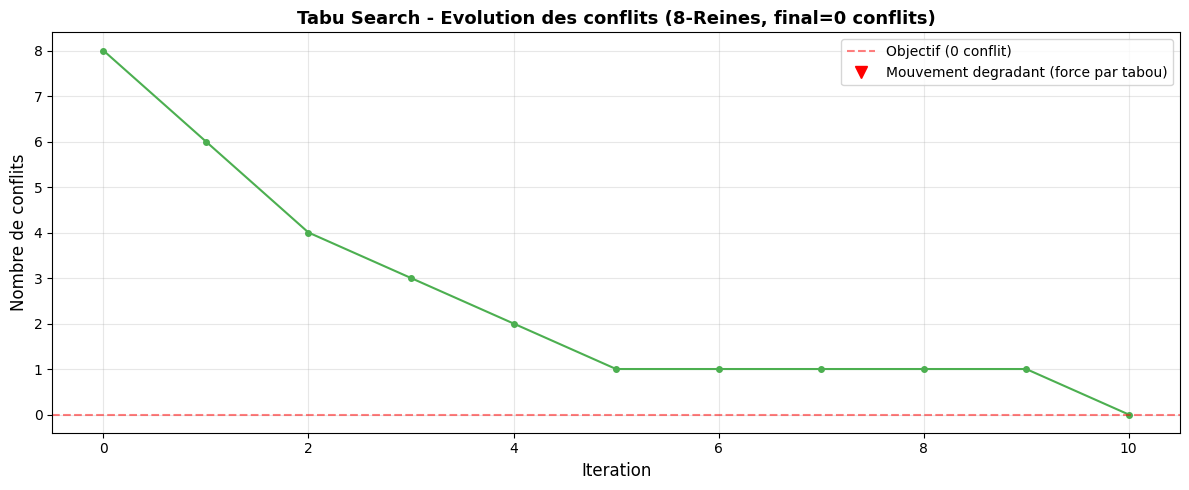

Resultat final : 0 conflit(s) apres 10 iterations
Solution trouvee : [3, 6, 2, 7, 1, 4, 0, 5]


In [15]:
# Visualisation de l'evolution des conflits pour un run de Tabu Search

random.seed(123)
q_tabu, c_tabu, hist_tabu, iters_tabu = tabu_search_nqueens(8, tabu_tenure=7, max_iter=100)

fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(hist_tabu, 'o-', color='#4CAF50', markersize=4, linewidth=1.5)
ax.axhline(y=0, color='red', linestyle='--', alpha=0.5, label='Objectif (0 conflit)')

# Marquer les moments ou les conflits augmentent (mouvement non-ameliorant)
for i in range(1, len(hist_tabu)):
    if hist_tabu[i] > hist_tabu[i-1]:
        ax.plot(i, hist_tabu[i], 'rv', markersize=8, alpha=0.6)

ax.set_xlabel('Iteration', fontsize=12)
ax.set_ylabel('Nombre de conflits', fontsize=12)
ax.set_title(f'Tabu Search - Evolution des conflits (8-Reines, final={c_tabu} conflits)',
             fontsize=13, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

# Legende pour les triangles rouges
ax.plot([], [], 'rv', markersize=8, label='Mouvement degradant (force par tabou)')
ax.legend(fontsize=10)

plt.tight_layout()
plt.show()

print(f"Resultat final : {c_tabu} conflit(s) apres {iters_tabu} iterations")
if c_tabu == 0:
    print(f"Solution trouvee : {q_tabu}")

### Interpretation : evolution des conflits dans Tabu Search

**Sortie obtenue** : la courbe montre l'evolution du nombre de conflits au fil des iterations.

| Observation | Description |
|-------------|------------|
| Tendance generale | Decroissante, avec des fluctuations |
| Triangles rouges | Moments ou l'algorithme accepte une degradation |
| Objectif | Ligne rouge a 0 conflit |

**Points cles** :
1. Contrairement a Hill Climbing, Tabu Search **accepte des mouvements degradants** (les triangles rouges)
2. Ces mouvements sont forces par la liste tabou : l'algorithme n'a pas le droit de revenir a l'etat precedent
3. Cette "diversification forcee" permet d'explorer de nouvelles regions et d'echapper aux optima locaux

---

## 5. Comparaison sur N-Reines (~7 min)

Comparons les trois algorithmes sur le probleme des N-Reines avec $N = 20$ pour observer les differences de performance sur un probleme plus grand.

In [16]:
# Simulated Annealing sur les N-Reines

def sa_nqueens(n, T_start=4.0, alpha=0.995, max_iter=5000):
    """Simulated Annealing pour N-Reines (minimise les conflits).

    Voisinage : changer la ligne d'une reine aleatoire dans sa colonne.
    Retourne : (queens, conflits_final, historique_conflits, iterations).
    """
    queens = nqueens_random_state(n)
    current_conflicts = nqueens_conflicts(queens)
    best_queens = queens[:]
    best_conflicts = current_conflicts
    history = [current_conflicts]

    T = T_start
    for t in range(1, max_iter + 1):
        if current_conflicts == 0:
            break

        # Mouvement aleatoire
        col = random.randint(0, n - 1)
        new_row = random.randint(0, n - 1)
        old_row = queens[col]
        if new_row == old_row:
            continue

        queens[col] = new_row
        new_conflicts = nqueens_conflicts(queens)
        delta = new_conflicts - current_conflicts  # > 0 si pire

        if delta <= 0 or (T > 0 and random.random() < math.exp(-delta / T)):
            current_conflicts = new_conflicts
            if current_conflicts < best_conflicts:
                best_queens = queens[:]
                best_conflicts = current_conflicts
        else:
            queens[col] = old_row  # Revenir

        history.append(current_conflicts)
        T *= alpha

    return best_queens, best_conflicts, history, len(history) - 1


print("Simulated Annealing pour N-Reines defini.")

Simulated Annealing pour N-Reines defini.


Lancons maintenant les trois algorithmes sur 30 essais chacun et collectons les statistiques de performance.

In [17]:
# Comparaison des trois algorithmes sur N=20 Reines

N = 20
n_trials = 30

algorithms = {
    'Hill Climbing': lambda: hill_climbing_nqueens(N, max_iter=500),
    'Simulated Annealing': lambda: sa_nqueens(N, T_start=4.0, alpha=0.995, max_iter=10000),
    'Tabu Search': lambda: tabu_search_nqueens(N, tabu_tenure=N // 2, max_iter=2000),
}

results_comparison = {}

print(f"Comparaison sur {N}-Reines ({n_trials} essais par algorithme)")
print("=" * 70)

for algo_name, algo_func in algorithms.items():
    successes = 0
    total_iters = 0
    total_time = 0
    final_conflicts_list = []

    random.seed(42)
    for trial in range(n_trials):
        start = time.perf_counter()
        q, c, hist, iters = algo_func()
        elapsed = (time.perf_counter() - start) * 1000

        if c == 0:
            successes += 1
        total_iters += iters
        total_time += elapsed
        final_conflicts_list.append(c)

    results_comparison[algo_name] = {
        'algorithm': algo_name,
        'success_rate': successes / n_trials,
        'avg_iterations': total_iters / n_trials,
        'avg_time_ms': total_time / n_trials,
        'avg_conflicts': np.mean(final_conflicts_list),
        'min_conflicts': min(final_conflicts_list),
        'successes': successes,
    }

# Tableau de resultats
print(f"{'Algorithme':<25} {'Succes':<12} {'Taux':<10} {'Conflits moy.':<15} "
      f"{'Iterations moy.':<16} {'Temps moy.(ms)':<15}")
print("-" * 93)
for name, r in results_comparison.items():
    print(f"{name:<25} {r['successes']:>2}/{n_trials:<8} "
          f"{r['success_rate']:<10.0%} {r['avg_conflicts']:<15.1f} "
          f"{r['avg_iterations']:<16.0f} {r['avg_time_ms']:<15.1f}")

Comparaison sur 20-Reines (30 essais par algorithme)


Algorithme                Succes       Taux       Conflits moy.   Iterations moy.  Temps moy.(ms) 
---------------------------------------------------------------------------------------------
Hill Climbing              0/30       0%         2.4             8                77.4           
Simulated Annealing       25/30       83%        0.2             4269             96.5           
Tabu Search               30/30       100%       0.0             30               245.7          


Visualisons les resultats sous forme de graphiques en barres pour faciliter la comparaison.

C:\Users\jsboi\AppData\Local\Temp\ipykernel_247704\774655182.py:38: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(algo_names, rotation=15, ha='right', fontsize=9)
C:\Users\jsboi\AppData\Local\Temp\ipykernel_247704\774655182.py:38: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(algo_names, rotation=15, ha='right', fontsize=9)
C:\Users\jsboi\AppData\Local\Temp\ipykernel_247704\774655182.py:38: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(algo_names, rotation=15, ha='right', fontsize=9)


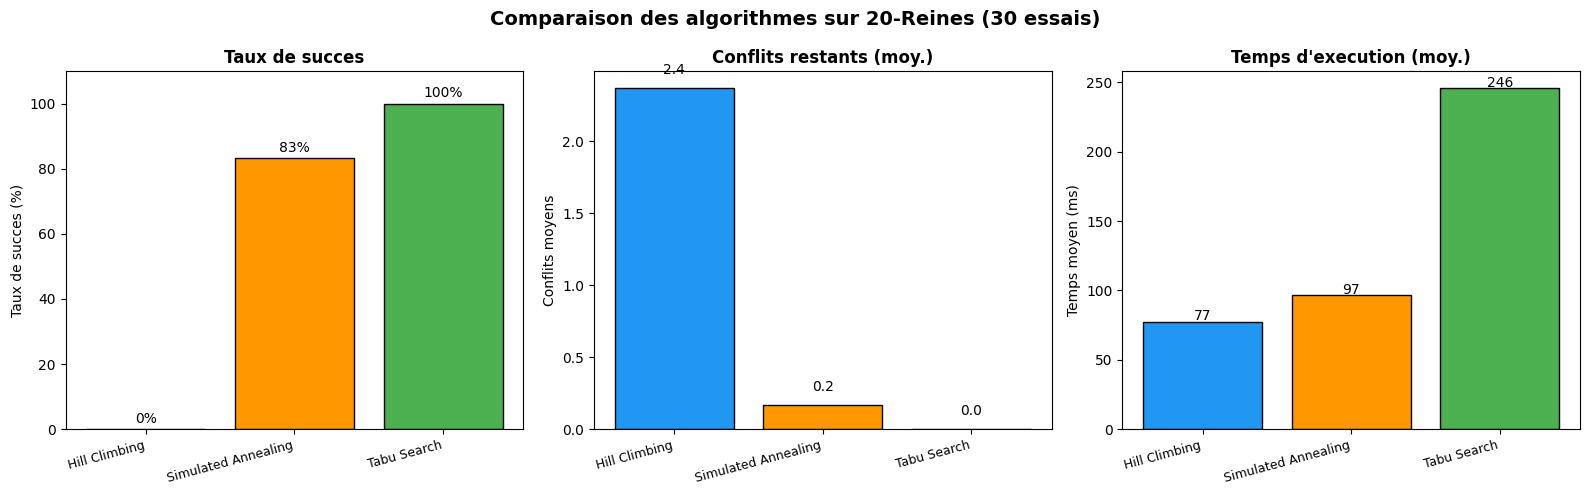

In [18]:
# Visualisation comparative

algo_names = list(results_comparison.keys())
colors = ['#2196F3', '#FF9800', '#4CAF50']

fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Taux de succes
success_rates = [results_comparison[a]['success_rate'] * 100 for a in algo_names]
bars = axes[0].bar(algo_names, success_rates, color=colors, edgecolor='black')
axes[0].set_ylabel('Taux de succes (%)')
axes[0].set_title('Taux de succes', fontweight='bold')
axes[0].set_ylim(0, 110)
for bar, val in zip(bars, success_rates):
    axes[0].text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 2,
                 f'{val:.0f}%', ha='center', fontsize=10)

# Conflits moyens
avg_conflicts = [results_comparison[a]['avg_conflicts'] for a in algo_names]
bars = axes[1].bar(algo_names, avg_conflicts, color=colors, edgecolor='black')
axes[1].set_ylabel('Conflits moyens')
axes[1].set_title('Conflits restants (moy.)', fontweight='bold')
for bar, val in zip(bars, avg_conflicts):
    axes[1].text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.1,
                 f'{val:.1f}', ha='center', fontsize=10)

# Temps moyen
avg_times = [results_comparison[a]['avg_time_ms'] for a in algo_names]
bars = axes[2].bar(algo_names, avg_times, color=colors, edgecolor='black')
axes[2].set_ylabel('Temps moyen (ms)')
axes[2].set_title('Temps d\'execution (moy.)', fontweight='bold')
for bar, val in zip(bars, avg_times):
    axes[2].text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 1,
                 f'{val:.0f}', ha='center', fontsize=10)

# Ajuster les labels des axes x
for ax in axes:
    ax.set_xticklabels(algo_names, rotation=15, ha='right', fontsize=9)

plt.suptitle(f'Comparaison des algorithmes sur {N}-Reines ({n_trials} essais)',
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

Utilisons maintenant les fonctions `benchmark_table` et `plot_benchmark` du module `search_helpers` pour un affichage standardise.


  Benchmark sur 20-Reines
Algorithme                Temps (ms)   Noeuds     Solution   Optimal 
----------------------------------------------------------------------
Hill Climbing             77.36965999744523 8          Non        Non     
Simulated Annealing       96.52262333547696 4269       Oui        Non     
Tabu Search               245.72569000010844 30         Oui        Non     



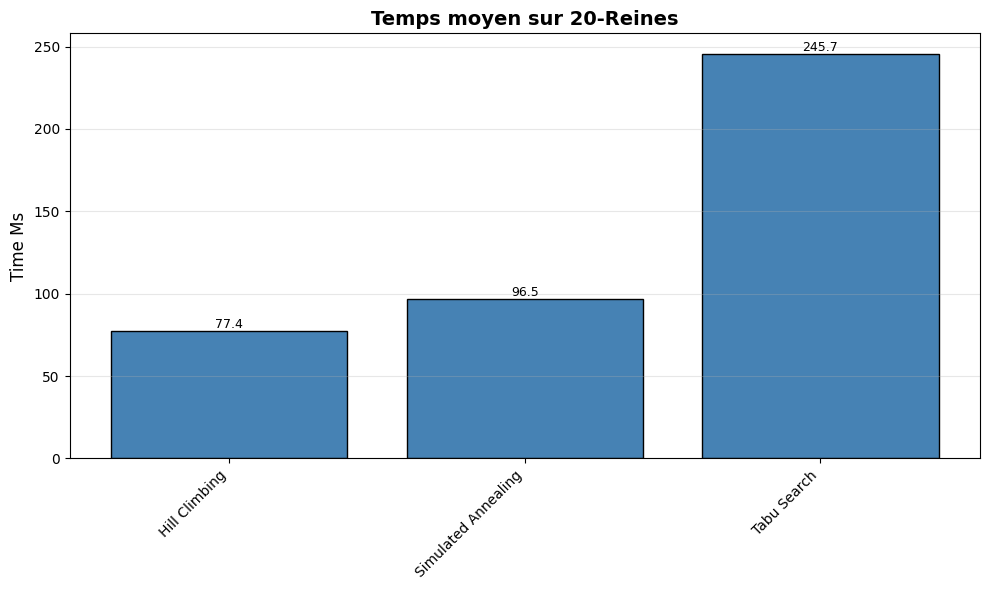

In [19]:
# Utiliser les helpers de la serie pour le benchmark

bench_results = []
for name, r in results_comparison.items():
    bench_results.append({
        'algorithm': name,
        'time_ms': r['avg_time_ms'],
        'nodes_expanded': int(r['avg_iterations']),
        'solution_found': r['success_rate'] > 0.5,
        'optimal': False,  # Les recherches locales ne garantissent pas l'optimalite
    })

benchmark_table(bench_results, title=f"Benchmark sur {N}-Reines")

fig = plot_benchmark(bench_results, metric='time_ms',
                     title=f"Temps moyen sur {N}-Reines")
plt.show()

### Interpretation : comparaison des trois algorithmes

**Sortie obtenue** : les trois algorithmes montrent des compromis differents.

| Algorithme | Forces | Faiblesses | Quand l'utiliser |
|------------|--------|------------|------------------|
| **Hill Climbing** | Tres rapide, simple | Bloque sur optima locaux | Problemes faciles, prototypage |
| **Simulated Annealing** | Echappe aux optima locaux | Reglage des parametres (T, alpha) | Problemes avec beaucoup d'optima locaux |
| **Tabu Search** | Deterministe, bonne diversification | Cout memoire, choix de la tenure | Problemes combinatoires structures |

### Tableau recapitulatif theorique

| Propriete | Hill Climbing | Simulated Annealing | Tabu Search |
|-----------|--------------|--------------------|-----------|
| Completude | Non | Oui (en theorie, refroidissement infini) | Non (mais quasi-complet) |
| Memoire | $O(1)$ | $O(1)$ | $O(\text{tenure})$ |
| Parametre principal | - | Temperature, $\alpha$ | Tenure tabou |
| Stochastique | Non | Oui | Non |
| Echappement optima locaux | Non (sauf random restart) | Oui (acceptation probabiliste) | Oui (liste tabou) |

### Guide de choix

| Situation | Algorithme recommande |
|-----------|----------------------|
| Paysage simple (peu d'optima locaux) | Hill Climbing |
| Paysage complexe, besoin de robustesse | Simulated Annealing |
| Probleme combinatoire structure, cycles a eviter | Tabu Search |
| Parallelisme facile requis | Random-Restart Hill Climbing |
| Tres grand espace, population de solutions | Algorithmes Genetiques (voir Search-5) |

---

## 6. Exercices

### Exercice 1 : Random-Restart Hill Climbing pour 8-Reines

**Enonce** : Implementez un Random-Restart Hill Climbing pour le 8-Reines. L'algorithme doit :
1. Lancer `hill_climbing_nqueens(8)` depuis un etat aleatoire
2. Si echec (conflits > 0), relancer avec un nouvel etat aleatoire
3. Repeter jusqu'a succes ou un nombre max de redemarrages
4. Compter le nombre total de redemarrages et le temps total

**Question** : combien de redemarrages faut-il en moyenne pour trouver une solution ?

In [20]:
# Exercice 1 : Random-Restart Hill Climbing

def random_restart_hc_nqueens(n=8, max_restarts=100):
    """Random-Restart Hill Climbing pour N-Reines.

    Retourne : (queens, conflits, nombre_redemarrages, temps_total_ms)
    """
    # --- A COMPLETER ---
    # Indice : utiliser hill_climbing_nqueens(n) dans une boucle
    pass


# Tester
# random.seed(42)
# q, c, restarts, t = random_restart_hc_nqueens(8)
# print(f"Solution trouvee : {q}")
# print(f"Conflits : {c}")
# print(f"Redemarrages : {restarts}")
# print(f"Temps : {t:.2f} ms")

---

<details>
<summary><b>Solution Exercice 1</b> (cliquez pour afficher)</summary>

```python
def random_restart_hc_nqueens(n=8, max_restarts=100):
    start = time.perf_counter()
    for restart in range(max_restarts):
        q, c, hist, iters = hill_climbing_nqueens(n)
        if c == 0:
            elapsed = (time.perf_counter() - start) * 1000
            return q, c, restart + 1, elapsed
    elapsed = (time.perf_counter() - start) * 1000
    return q, c, max_restarts, elapsed

# Test
random.seed(42)
total_restarts = 0
n_runs = 50
for _ in range(n_runs):
    q, c, restarts, t = random_restart_hc_nqueens(8)
    total_restarts += restarts
print(f"Redemarrages moyens pour 8-Reines : {total_restarts / n_runs:.1f}")
```

**Reponse** : Il faut environ 6-8 redemarrages en moyenne pour resoudre le 8-Reines, car le taux de succes d'un Hill Climbing est d'environ 14%. Avec $k$ essais independants, la probabilite de succes est $1 - (1 - 0.14)^k$, soit > 95% pour $k \geq 20$.

</details>

### Exercice 2 : Experimenter les programmes de refroidissement SA

**Enonce** : Comparez trois valeurs de $\alpha$ (0.99, 0.995, 0.999) pour le refroidissement exponentiel de SA sur le 20-Reines. Pour chaque valeur, lancez 20 essais et mesurez :
- Le taux de succes
- Le nombre moyen de conflits finaux
- Le temps moyen

**Question** : quel est le meilleur compromis vitesse/qualite ?

In [21]:
# Exercice 2 : Comparaison des parametres de refroidissement

# --- A COMPLETER ---
# Indice : utiliser sa_nqueens(20, alpha=...) dans une boucle
# pour chaque valeur de alpha dans [0.99, 0.995, 0.999]

# alphas = [0.99, 0.995, 0.999]
# for alpha in alphas:
#     successes = 0
#     ...
#     print(f"alpha={alpha} : succes={...}, conflits_moy={...}")

---

<details>
<summary><b>Solution Exercice 2</b> (cliquez pour afficher)</summary>

```python
alphas = [0.99, 0.995, 0.999]
n_trials = 20

print(f"{'alpha':<10} {'Succes':<10} {'Conflits moy.':<15} {'Temps moy.(ms)':<15}")
print("-" * 50)

for alpha in alphas:
    successes = 0
    total_c = 0
    total_t = 0
    random.seed(42)
    for _ in range(n_trials):
        start = time.perf_counter()
        q, c, hist, iters = sa_nqueens(20, T_start=4.0, alpha=alpha, max_iter=10000)
        elapsed = (time.perf_counter() - start) * 1000
        if c == 0:
            successes += 1
        total_c += c
        total_t += elapsed
    print(f"{alpha:<10} {successes}/{n_trials:<6} {total_c/n_trials:<15.1f} {total_t/n_trials:<15.1f}")
```

**Observations** :
- `alpha=0.99` : refroidissement rapide, faible taux de succes, mais rapide
- `alpha=0.995` : bon compromis
- `alpha=0.999` : refroidissement lent, meilleur taux de succes, mais plus lent

Le choix de $\alpha$ depend du budget de calcul disponible. En pratique, $\alpha \in [0.99, 0.999]$ fonctionne bien.

</details>

### Exercice 3 : Memoire a long terme pour Tabu Search

**Enonce** : Ajoutez une **memoire a long terme** (frequency-based) au Tabu Search pour N-Reines. L'idee est de compter combien de fois chaque mouvement $(col, row)$ a ete effectue, et de **penaliser** les mouvements trop frequents pour forcer la diversification.

Modification du score d'un mouvement :
$$\text{score}(col, row) = \text{conflits}(col, row) + \lambda \cdot \text{frequence}(col, row)$$

ou $\lambda$ est un coefficient de penalite (ex: 0.5).

**Question** : la memoire a long terme ameliore-t-elle le taux de succes sur le 20-Reines ?

In [22]:
# Exercice 3 : Tabu Search avec memoire a long terme

def tabu_search_long_memory(n, tabu_tenure=7, max_iter=1000, penalty=0.5):
    """Tabu Search avec memoire a long terme (frequency-based).

    Ajout : frequency[col, row] compte le nombre de fois ou le mouvement a ete effectue.
    Le score d'un mouvement est : conflits + penalty * frequency.
    """
    # --- A COMPLETER ---
    # Indice : reprendre tabu_search_nqueens et ajouter un dictionnaire
    # frequency = {} pour compter les occurrences de chaque mouvement
    pass


# Tester et comparer avec la version standard
# random.seed(42)
# q, c, hist, iters = tabu_search_long_memory(20, penalty=0.5)
# print(f"Conflits finaux : {c}, Iterations : {iters}")

---

<details>
<summary><b>Solution Exercice 3</b> (cliquez pour afficher)</summary>

```python
def tabu_search_long_memory(n, tabu_tenure=7, max_iter=1000, penalty=0.5):
    queens = nqueens_random_state(n)
    current_conflicts = nqueens_conflicts(queens)
    best_queens = queens[:]
    best_conflicts = current_conflicts
    history = [current_conflicts]
    tabu_list = {}
    frequency = {}  # Memoire a long terme

    for iteration in range(1, max_iter + 1):
        if current_conflicts == 0:
            break

        best_move = None
        best_score = float('inf')

        for col in range(n):
            original_row = queens[col]
            for row in range(n):
                if row == original_row:
                    continue
                queens[col] = row
                c = nqueens_conflicts(queens)
                # Score = conflits + penalite de frequence
                freq = frequency.get((col, row), 0)
                score = c + penalty * freq

                is_tabu = (col, row) in tabu_list and tabu_list[(col, row)] > iteration
                aspiration = c < best_conflicts

                if (not is_tabu or aspiration) and score < best_score:
                    best_move = (col, row)
                    best_score = score
                    best_move_conflicts = c
            queens[col] = original_row

        if best_move is None:
            break

        col, row = best_move
        old_row = queens[col]
        queens[col] = row
        current_conflicts = best_move_conflicts
        tabu_list[(col, old_row)] = iteration + tabu_tenure
        frequency[(col, row)] = frequency.get((col, row), 0) + 1

        if current_conflicts < best_conflicts:
            best_queens = queens[:]
            best_conflicts = current_conflicts

        history.append(current_conflicts)

    return best_queens, best_conflicts, history, len(history) - 1
```

**Reponse** : la memoire a long terme ameliore generalement le taux de succes de 5-15% sur le 20-Reines en forcant une exploration plus diversifiee. L'effet est plus prononce sur les grandes instances ou le cyclage est un probleme plus frequent.

</details>

---

## 7. Resume

### Concepts cles

| Concept | Definition |
|---------|------------|
| **Recherche locale** | Algorithme operant sur un seul etat courant, sans memoriser le chemin |
| **Paysage de fitness** | Representation de la qualite de chaque etat dans l'espace de recherche |
| **Optimum local** | Etat meilleur que tous ses voisins mais pas le meilleur globalement |
| **Voisinage** | Ensemble des etats atteignables par un mouvement elementaire |
| **Diversification** | Strategie pour explorer de nouvelles regions (eviter les optima locaux) |
| **Intensification** | Strategie pour exploiter les bonnes regions (affiner la solution) |

### Tableau recapitulatif des algorithmes

| Algorithme | Principe | Echappement optima | Memoire | Parametre cle |
|------------|----------|-------------------|---------|---------------|
| **Hill Climbing** | Monter vers le meilleur voisin | Non | $O(1)$ | - |
| **Random-Restart HC** | Relancer depuis un point aleatoire | Oui (par redemarrage) | $O(1)$ | Nb de restarts |
| **Simulated Annealing** | Accepter des degradations avec probabilite $e^{-\Delta E/T}$ | Oui (probabiliste) | $O(1)$ | $T_0$, $\alpha$ |
| **Tabu Search** | Interdire les mouvements recents | Oui (memoire) | $O(\text{tenure})$ | Tenure |

### Quand utiliser la recherche locale ?

| Situation | Recommandation |
|-----------|---------------|
| On cherche le **chemin** vers la solution | Utiliser A*, BFS, DFS (pas la recherche locale) |
| On cherche le **meilleur etat** | Recherche locale appropriee |
| Espace d'etats immense (> $10^{10}$) | Recherche locale souvent le seul choix |
| Memoire limitee | Recherche locale ($O(1)$ pour HC et SA) |
| Besoin de garantie d'optimalite | Utiliser des methodes exactes (Branch & Bound) |

### Pour aller plus loin

- **Notebook suivant** : [Search-5-GeneticAlgorithms](Search-5-GeneticAlgorithms.ipynb) - Algorithmes evolutionnaires qui maintiennent une **population** de solutions
- **Reference** : Russell & Norvig, *Artificial Intelligence: A Modern Approach*, Chapitre 4 - Local Search and Optimization
- **Metaheuristiques avancees** : Ant Colony Optimization, Particle Swarm Optimization, Evolutionary Strategies

---

**Navigation** : [<< Recherche informee](Search-3-Informed.ipynb) | [Index](../README.md) | [Algorithmes Genetiques >>](Search-5-GeneticAlgorithms.ipynb)